# Ссылка на репозиторий https://github.com/MiguelGerMal/Project-2

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [3]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('Churn.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df['Tenure'] = df['Tenure'].astype(int)


Предварительно посмотрим на соотношение классов в целевом признаке

In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Присутствует дисбаланс

Разобьем исходный датасет на тестовую и валидационную выборки, при этом для категориальных признаков сделаем OHE-кодирование через get_dummy. Также выкинем из датасета столбцы RowNumber (потому что он дублирует индекс, CustomerId, Surname)

In [6]:
df_ohe = pd.get_dummies(df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1), drop_first = True)
target = df_ohe['Exited']
features = df_ohe.drop(['Exited'] , axis=1)
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=1/4, random_state=12345)

print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


Для всех столбцов, которые являются недискретными/не являются категориальными (хотя возраст можно и сделать категориальным, но пусть будет пока так) стандартизируем все данные (чтобы абсолютный размер дисперсии не был определяющим фактором)

In [7]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']

In [8]:

warnings.filterwarnings("ignore")


scaler = StandardScaler()
scaler.fit(features[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

In [10]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train, target_train)

LogisticRegression(random_state=12345, solver='liblinear')

Посмотрим на матрицу запутанности (Confusion Matrix)


In [11]:
predictions = model.predict(features_valid)
confusion_matrix(target_valid, predictions)

array([[1549,   60],
       [ 311,   80]])

Много ложноотрицательных результатов (4 из 5 действительно положительных результатов будут отрицательными), 508 неправильных ответов (всего 20,3%)

In [12]:
print('recall', recall_score(target_valid, predictions))
print('precision', precision_score(target_valid, predictions))
print('f1_score', f1_score(target_valid, predictions))

recall 0.20460358056265984
precision 0.5714285714285714
f1_score 0.30131826741996237


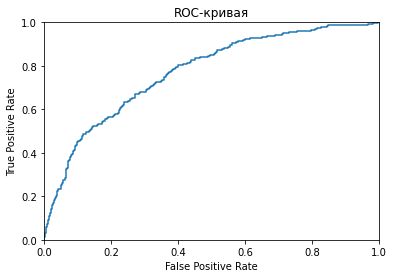

In [13]:
probabilities_valid = model.predict_proba(features_valid)
probabilites_one_valid = probabilities_valid[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

In [14]:
auc_roc = roc_auc_score(target_valid, probabilites_one_valid)
print(auc_roc)

0.7703391568208876


Подберем оптимальную глубину DecisionTree

In [16]:
tree = DecisionTreeClassifier(random_state=12345)
tree.fit(features_train, target_train)

DecisionTreeClassifier(random_state=12345)

In [17]:
best_f1_score = 0
best_depth = 0

for depth in range(1, 6):
    tree = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    tree.fit(features_train, target_train)
    predictions = tree.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    if f1>best_f1_score:
        best_depth = depth
        best_f1_score = f1

print('best_depth', depth)
print('best_f1_score', best_f1_score)

best_depth 5
best_f1_score 0.5496894409937887


Измерим accuracy_score, confusion_matrix, precision и recall для дерева глубиной 5

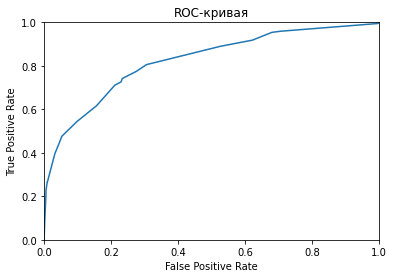

accuracy_score 0.855
precision_score 0.6996047430830039
recall_score 0.45268542199488493


array([[1533,   76],
       [ 214,  177]])

In [18]:
tree =  tree = DecisionTreeClassifier(random_state=12345, max_depth = 5)
tree.fit(features_train, target_train)
probabilities_valid = tree.predict_proba(features_valid)
probabilites_one_valid = probabilities_valid[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

predictions = tree.predict(features_valid)
print('accuracy_score', accuracy_score(target_valid, predictions))
print('precision_score', precision_score(target_valid, predictions))
print('recall_score', recall_score(target_valid, predictions))
confusion_matrix(target_valid, predictions)

15% ошибок всего, recall примерно 50% (модель плохо определяет положительный класс)

Рассмотрим график precision-recall

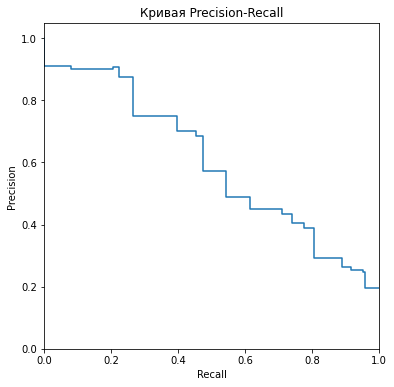

In [19]:
probabilities_valid = tree.predict_proba(features_valid)

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()


никаких пиков нет

In [21]:
best_f1_score_forest = 0
best_est_forest = 0
best_depth = 0
for est in range(10, 200, 10):
    for depth in range(1,10):
        forest = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators = est)
        forest.fit(features_train, target_train)
        predictions = forest.predict(features_valid)
        f1 = f1_score(target_valid, predictions)
        if f1>best_f1_score_forest:
            best_est_forest = est
            best_f1_score_forest = f1
            best_depth = depth
print('best_est_forest', est)
print('best_f1_score_forest', best_f1_score_forest)
print('best_depth', best_depth)

best_est_forest 190
best_f1_score_forest 0.5490196078431372
best_depth 9


проверим все другие метрики

best_depth 9


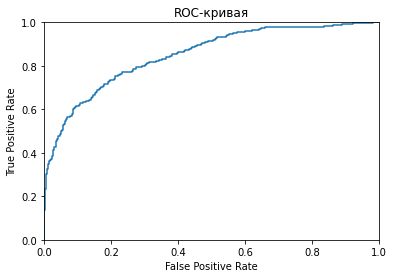

accuracy_score 0.863
precision_score 0.7799043062200957
recall_score 0.41687979539641945
f1_score 0.5433333333333333


array([[1563,   46],
       [ 228,  163]])

In [22]:
best_f1_score_forest = 0
best_depth = 0
for i in range(1, 10): 
    forest = RandomForestClassifier(random_state=12345, max_depth = i)
    forest.fit(features_train, target_train)
    predictions = forest.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    if f1>best_f1_score_forest:
        best_f1_score_forest = f1
        best_depth = i

print('best_depth', best_depth)
forest = RandomForestClassifier(random_state=12345, max_depth = best_depth)
forest.fit(features_train, target_train)
probabilities_valid = forest.predict_proba(features_valid)
probabilites_one_valid = probabilities_valid[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

predictions = forest.predict(features_valid)
print('accuracy_score', accuracy_score(target_valid, predictions))
print('precision_score', precision_score(target_valid, predictions))
print('recall_score', recall_score(target_valid, predictions))
print('f1_score', f1_score(target_valid, predictions))
confusion_matrix(target_valid, predictions)


## Борьба с дисбалансом

Используем class_weight = 'balanced'

best_depth 9
best_est 190
accuracy_score 0.827
precision_score 0.551487414187643
recall_score 0.6163682864450127
f1_score 0.5821256038647343
roc_auc_score 0.5026121419564042


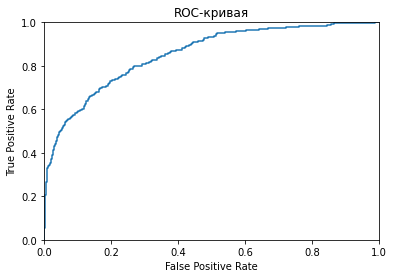

array([[1413,  196],
       [ 150,  241]])

In [26]:
best_depth = 0
best_roc_auc = 0

for depth in range(1,10):
    forest = RandomForestClassifier(random_state=12345, max_depth = depth, class_weight = 'balanced')
    #forest.fit(features_valid, target_valid)    
    forest.fit(features_train, target_train)
    probabilities_valid = forest.predict_proba(features_valid)
    probabilites_one_valid = probabilities_valid[:,1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
    if roc_auc_score(target_valid, probabilites_one_valid)>best_roc_auc:
        best_depth = depth
        best_est = est
print('best_depth', best_depth)
print('best_est', best_est)
forest = RandomForestClassifier(random_state=12345, max_depth = best_depth, class_weight = 'balanced')
forest.fit(features_train, target_train)

predictions = forest.predict(features_valid)
print('accuracy_score', accuracy_score(target_valid, predictions))
print('precision_score', precision_score(target_valid, predictions))
print('recall_score', recall_score(target_valid, predictions))
print('f1_score', f1_score(target_valid, predictions))

probabilities_valid = forest.predict_proba(features_valid)
probabilites_one_valid = probabilities_valid[:,1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
print('roc_auc_score', roc_auc_score(target_test, probabilites_one_valid))


plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()
confusion_matrix(target_valid, predictions)

проверим на тестовой выборке метрики

accuracy_score 0.827
precision_score 0.551487414187643
recall_score 0.6163682864450127
f1_score 0.5821256038647343
roc_auc_score 0.8532566970636716


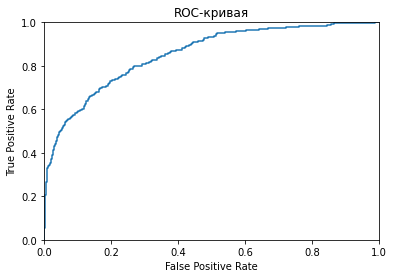

array([[1413,  196],
       [ 150,  241]])

In [37]:
best_f1_score = 0
best_depth = 0

for depth in range(1, 6):
    tree = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    tree.fit(features_train, target_train)
    predictions = tree.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    if f1>best_f1_score:
        best_depth = depth
        best_f1_score = f1

print('best_depth', depth)
print('best_f1_score', best_f1_score)


tree = DecisionTreeClassifier(random_state=12345, max_depth = best_depth, class_weight = 'balanced')
tree.fit(features_train, target_train)

predictions = tree.predict(features_valid)
print('accuracy_score', accuracy_score(target_valid, predictions))
print('precision_score', precision_score(target_valid, predictions))
print('recall_score', recall_score(target_valid, predictions))
print('f1_score', f1_score(target_valid, predictions))

probabilities_valid = tree.predict_proba(features_valid)
probabilites_one_valid = probabilities_valid[:,1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
print('roc_auc_score', roc_auc_score(target_test, probabilites_one_valid))


plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()
confusion_matrix(target_valid, predictions)

In [ ]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight = 'balanced')
model.fit(features_train, target_train)

predictions = model.predict(features_valid)
print('accuracy_score', accuracy_score(target_valid, predictions))
print('precision_score', precision_score(target_valid, predictions))
print('recall_score', recall_score(target_valid, predictions))
print('f1_score', f1_score(target_valid, predictions))

probabilities_valid = model.predict_proba(features_valid)
probabilites_one_valid = probabilities_valid[:,1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
print('roc_auc_score', roc_auc_score(target_valid, probabilites_one_valid))


plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()
confusion_matrix(target_valid, predictions)

достигнут нужный уровень f1_score

In [28]:
target_train.sum()/len(target_train)*100

20.316666666666666

положительных результатов 20%, хочу использовать upsampling

In [30]:
repeat = int(len(target)/sum(target))

features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

features_upsampled = shuffle(pd.concat([features_zeros] + [features_ones] * repeat), random_state = 12345)
target_upsampled = shuffle(pd.concat([target_zeros] + [target_ones] * repeat), random_state = 12345)

print(features_upsampled.shape)
print(target_upsampled.shape)
target_upsampled.sum()

(9657, 11)
(9657,)


4876

best_depth 8
best_est 190
best_roc_auc_score 0.8538559477618702
accuracy_score 0.81
precision_score 0.5104364326375711
recall_score 0.6879795396419437
f1_score 0.5860566448801742
roc_auc_score 0.8538559477618702


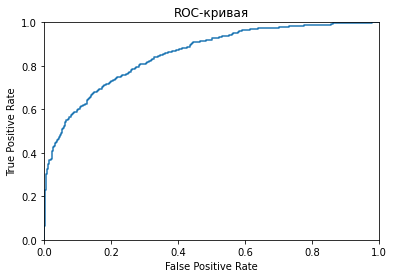

array([[1351,  258],
       [ 122,  269]])

In [53]:
best_depth = 0
best_roc_auc_score = 0
best_est = 0

for depth in range(1,9):
    for est in range(100, 200, 10):
        forest = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators = est)
        forest.fit(features_upsampled, target_upsampled)
        probabilities_valid = forest.predict_proba(features_valid)
        probabilites_one_valid = probabilities_valid[:,1]
        if roc_auc_score(target_valid, probabilites_one_valid)>best_roc_auc_score:
            best_depth = depth
            best_roc_auc_score = roc_auc_score(target_valid, probabilites_one_valid)
            best_est = est

print('best_depth', depth)
print('best_est', best_est)
print('best_roc_auc_score', best_roc_auc_score)
        
forest = RandomForestClassifier(random_state=12345, max_depth = best_depth, n_estimators = best_est)
forest.fit(features_upsampled, target_upsampled)


predictions = forest.predict(features_valid)
print('accuracy_score', accuracy_score(target_valid, predictions))
print('precision_score', precision_score(target_valid, predictions))
print('recall_score', recall_score(target_valid, predictions))
print('f1_score', f1_score(target_valid, predictions))

probabilities_valid = forest.predict_proba(features_valid)
probabilites_one_valid = probabilities_valid[:,1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
print('roc_auc_score', roc_auc_score(target_valid, probabilites_one_valid))


plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()
confusion_matrix(target_valid, predictions)

посмотрим на логистическую регрессию (измениться ли что-то)

accuracy_score 0.703
precision_score 0.363758389261745
recall_score 0.6930946291560103
f1_score 0.4771126760563381
roc_auc_score 0.7725676700274511


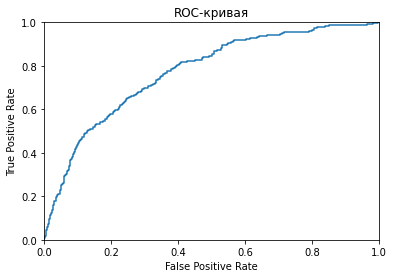

array([[1135,  474],
       [ 120,  271]])

In [44]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_upsampled, target_upsampled)

predictions = model.predict(features_valid)
print('accuracy_score', accuracy_score(target_valid, predictions))
print('precision_score', precision_score(target_valid, predictions))
print('recall_score', recall_score(target_valid, predictions))
print('f1_score', f1_score(target_valid, predictions))

probabilities_valid = model.predict_proba(features_valid)
probabilites_one_valid = probabilities_valid[:,1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
print('roc_auc_score', roc_auc_score(target_valid, probabilites_one_valid))


plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()
confusion_matrix(target_valid, predictions)

много ложноотрицательных, ниже f1_score чем у других моделей

accuracy_score 0.763
precision_score 0.4372163388804841
recall_score 0.7391304347826086
f1_score 0.5494296577946768
roc_auc_score 0.8193314778285189


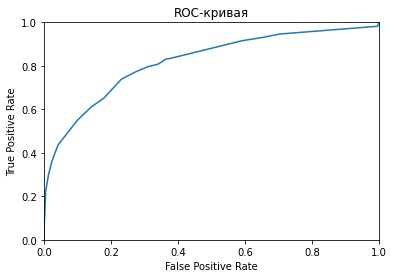

array([[1237,  372],
       [ 102,  289]])

In [47]:
best_depth = 0
best_roc_auc_score = 0
for depth in range(1,9):
    tree = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    tree.fit(features_upsampled, target_upsampled)
    probabilities_valid = tree.predict_proba(features_valid)
    probabilites_one_valid = probabilities_valid[:,1]
    if roc_auc_score(target_valid, probabilites_one_valid)>best_roc_auc_score:
        best_depth = depth
        best_n_estimators = est
        best_roc_auc_score = roc_auc_score(target_valid, probabilites_one_valid)

tree = DecisionTreeClassifier(random_state = 12345, max_depth = best_depth)
tree.fit(features_upsampled, target_upsampled)
predictions = tree.predict(features_valid)
print('accuracy_score', accuracy_score(target_valid, predictions))
print('precision_score', precision_score(target_valid, predictions))
print('recall_score', recall_score(target_valid, predictions))
print('f1_score', f1_score(target_valid, predictions))

probabilities_valid = tree.predict_proba(features_valid)
probabilites_one_valid = probabilities_valid[:,1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilites_one_valid)
print('roc_auc_score', roc_auc_score(target_valid, probabilites_one_valid))


plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()
confusion_matrix(target_valid, predictions)

также много ложноотрицательных, но стал выше recall по сравнению с изначальными выборками

## Тестирование модели

используем последние настройки RandomForest

roc_auc_score 0.8695090304628309
recall 0.7353629976580797
precision 0.5678119349005425
f1_score 0.6408163265306123


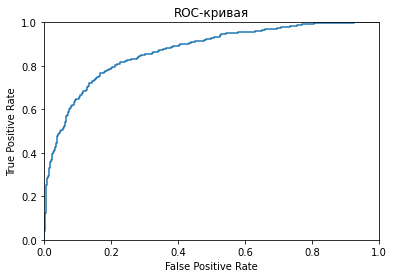

array([[1334,  239],
       [ 113,  314]])

In [56]:
predictions = forest.predict(features_test)

probabilities_test = forest.predict_proba(features_test)
probabilites_one_test = probabilities_test[:,1]

print('roc_auc_score', roc_auc_score(target_test, probabilites_one_test))
confusion_matrix(target_test, predictions)
print('recall', recall_score(target_test, predictions))
print('precision', precision_score(target_test, predictions))
print('f1_score', f1_score(target_test, predictions))


fpr, tpr, thresholds = roc_curve(target_test, probabilites_one_test)


plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()
confusion_matrix(target_test, predictions)

Метрики стали лучше

## Общий вывод

Лучше всего предсказывает факт ухода клиента из банка ансамбль деревьев. С параметрами глубины в 9 и количеством деревьев 190 получилось достичь следующих метрик:

roc_auc_score 0.87

recall 0.74

precision 0.57

f1_score 0.64


|             | True 0 | True 1 |
|-------------|--------|--------|
| Predicted 0 | 1334   | 239    |
| Predicted 1 | 113    | 314    |




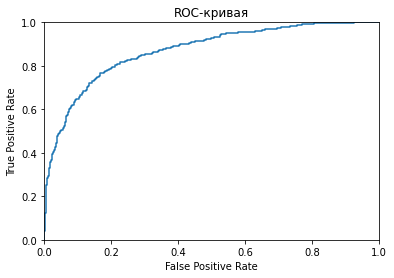